# VQE Implementation in Qiskit

all taken from https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [21]:
from qiskit.aqua.algorithms import VQE, NumPyEigensolver
import matplotlib.pyplot as plt
import numpy as np
from qiskit.chemistry.components.variational_forms import UCCSD
from qiskit.chemistry.components.initial_states import HartreeFock
from qiskit.circuit.library import EfficientSU2
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
from qiskit.aqua.operators import Z2Symmetries
from qiskit import IBMQ, BasicAer, Aer
from qiskit.chemistry.drivers import PySCFDriver, UnitsType
from qiskit.chemistry import FermionicOperator
from qiskit.aqua import QuantumInstance
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit.providers.aer.noise import NoiseModel


* PySCFDriver         at https://qiskit.org/documentation/stubs/qiskit.chemistry.drivers.PySCFDriver.html
* FermionicOperator   at https://qiskit.org/documentation/stubs/qiskit.chemistry.FermionicOperator.html
* WeigtedPaulOperator at https://qiskit.org/documentation/stubs/qiskit.aqua.operators.legacy.WeightedPauliOperator.html
* USSD at https://qiskit.org/documentation/_modules/qiskit/chemistry/components/variational_forms/uccsd.html

In [2]:
def get_qubit_op(dist):
    driver = PySCFDriver(atom="Li .0 .0 .0; H .0 .0 " + str(dist), unit=UnitsType.ANGSTROM, 
                         charge=0, spin=0, basis='sto3g')
    molecule = driver.run()
    freeze_list = [0]
    remove_list = [-3, -2]
    repulsion_energy = molecule.nuclear_repulsion_energy
    num_particles = molecule.num_alpha + molecule.num_beta
    num_spin_orbitals = molecule.num_orbitals * 2
    remove_list = [x % molecule.num_orbitals for x in remove_list]
    freeze_list = [x % molecule.num_orbitals for x in freeze_list]
    remove_list = [x - len(freeze_list) for x in remove_list]
    remove_list += [x + molecule.num_orbitals - len(freeze_list)  for x in remove_list]
    freeze_list += [x + molecule.num_orbitals for x in freeze_list]
    ferOp = FermionicOperator(h1=molecule.one_body_integrals, h2=molecule.two_body_integrals)
    ferOp, energy_shift = ferOp.fermion_mode_freezing(freeze_list)
    num_spin_orbitals -= len(freeze_list)
    num_particles -= len(freeze_list)
    ferOp = ferOp.fermion_mode_elimination(remove_list)
    num_spin_orbitals -= len(remove_list)
    qubitOp = ferOp.mapping(map_type='parity', threshold=0.00000001)
    qubitOp = Z2Symmetries.two_qubit_reduction(qubitOp, num_particles)
    shift = energy_shift + repulsion_energy
    return qubitOp, num_particles, num_spin_orbitals, shift


In [3]:
backend = BasicAer.get_backend("statevector_simulator")
distances = np.arange(0.5, 4.0, 0.1)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=5)
for dist in distances:
    qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(dist)
    result = NumPyEigensolver(qubitOp).run()
    exact_energies.append(np.real(result.eigenvalues) + shift)
    initial_state = HartreeFock(
        num_spin_orbitals,
        num_particles,
        qubit_mapping='parity'
    ) 
    var_form = UCCSD(
        num_orbitals=num_spin_orbitals,
        num_particles=num_particles,
        initial_state=initial_state,
        qubit_mapping='parity'
    )
    vqe = VQE(qubitOp, var_form, optimizer)
    vqe_result = np.real(vqe.run(backend)['eigenvalue'] + shift)
    vqe_energies.append(vqe_result)
    print("Interatomic Distance:", np.round(dist, 2), "VQE Result:", vqe_result, "Exact Energy:", exact_energies[-1])
    
print("All energies have been calculated")


Interatomic Distance: 0.5 VQE Result: -7.039710214069133 Exact Energy: [-7.03973252]
Interatomic Distance: 0.6 VQE Result: -7.313344302436685 Exact Energy: [-7.31334583]
Interatomic Distance: 0.7 VQE Result: -7.500921095928959 Exact Energy: [-7.50092209]
Interatomic Distance: 0.8 VQE Result: -7.630976915350816 Exact Energy: [-7.63097825]
Interatomic Distance: 0.9 VQE Result: -7.72081079472755 Exact Energy: [-7.72081241]
Interatomic Distance: 1.0 VQE Result: -7.782240655309355 Exact Energy: [-7.7822424]
Interatomic Distance: 1.1 VQE Result: -7.823597492995967 Exact Energy: [-7.82359928]
Interatomic Distance: 1.2 VQE Result: -7.850696622908224 Exact Energy: [-7.85069838]
Interatomic Distance: 1.3 VQE Result: -7.867561602162162 Exact Energy: [-7.86756329]
Interatomic Distance: 1.4 VQE Result: -7.876999876400026 Exact Energy: [-7.87700149]
Interatomic Distance: 1.5 VQE Result: -7.881014173887156 Exact Energy: [-7.88101572]
Interatomic Distance: 1.6 VQE Result: -7.881070663278019 Exact Ener

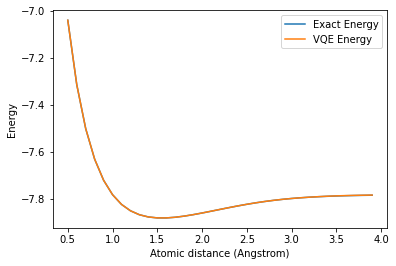

In [6]:
plt.plot(distances, exact_energies, label="Exact Energy")
plt.plot(distances, vqe_energies, label="VQE Energy")
plt.xlabel('Atomic distance (Angstrom)')
plt.ylabel('Energy')
plt.legend()
plt.show()


In [7]:
qubitOp, num_particles, num_spin_orbitals, shift = get_qubit_op(1.3)
                                                        

In [17]:
qubitOp.num_qubits

4

In [19]:
qubitOp.print_details()

'IIII\t(-0.19624488017342284+0j)\nIIIZ\t(-0.08741298837082455+0j)\nIIZX\t(-0.001888758054164783+0j)\nIIIX\t(0.001888758054164783+0j)\nIIXX\t(0.0011643387240968918+0j)\nIIYY\t(-0.0011643387240968918+0j)\nIIZZ\t(-0.21027042683592773+0j)\nIIXZ\t(0.02046874508349881+0j)\nIIXI\t(0.02046874508349881+0j)\nIIZI\t(0.3908458324060484+0j)\nIZII\t(0.08741298837082459+0j)\nZXII\t(0.0018887580541647874+0j)\nIXII\t(0.0018887580541647874+0j)\nXXII\t(0.0011643387240968864+0j)\nYYII\t(-0.0011643387240968864+0j)\nZZII\t(-0.21027042683592756+0j)\nXZII\t(-0.020468745083498805+0j)\nXIII\t(0.020468745083498805+0j)\nZIII\t(-0.3908458324060485+0j)\nIZIZ\t(-0.12706341392663112+0j)\nIZZX\t(0.010965819553473468+0j)\nIZIX\t(-0.010965819553473468+0j)\nIZXX\t(0.03611266801865108+0j)\nIZYY\t(-0.03611266801865108+0j)\nIXIZ\t(0.01096581955347347+0j)\nZXIZ\t(0.01096581955347347+0j)\nIXZX\t(-0.0026782907385780276+0j)\nZXZX\t(-0.0026782907385780276+0j)\nIXIX\t(0.0026782907385780276+0j)\nZXIX\t(0.0026782907385780276+0j)\nI

In [20]:
qubitOp.draw(output='mpl')

AttributeError: 'WeightedPauliOperator' object has no attribute 'draw'